#### -----------------------------------------------------------
#### Project Code : Python for Data Science
#### Students : Moustapha, Shishir, Shashank, 
#### MSc Big Data, ENSAI
#### -----------------------------------------------------------

#### Importing the different libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

##### Loading the data

In [2]:
dftr=pd.read_csv("train.csv")
dfte=pd.read_csv("test.csv")

In [ ]:
#dftr.head(5)

##### Setting the index

In [3]:
dftr=dftr.set_index("Id")
dfte=dfte.set_index("Id")

##### Creating an indicator to merge the test and the train data, in order to make the OHE

In [4]:
dftr['origin']="train"
dfte['origin']="test"
dfw=[dftr,dfte]
df1=pd.concat(dfw)

In [5]:
print(df1.columns)
df1.apply(lambda x: sum(x.isnull()),axis=0) 

Index(['Category', 'Company', 'ContractTime', 'ContractType',
       'FullDescription', 'LocationNormalized', 'LocationRaw',
       'SalaryNormalized', 'SalaryRaw', 'SourceName', 'Title', 'origin'],
      dtype='object')


Category                  0
Company                4340
ContractTime           6075
ContractType          10636
FullDescription           0
LocationNormalized        0
LocationRaw               0
SalaryNormalized       5000
SalaryRaw              5000
SourceName                0
Title                     1
origin                    0
dtype: int64

### Transforming the NA value

In [6]:
df1['Company'].fillna('NoCompany',inplace=True)
df1['ContractTime'].fillna('NoContractTime',inplace=True)
df1['ContractType'].fillna('ContractType',inplace=True)
df1['Title'].fillna('Title',inplace=True)
df1.apply(lambda x: sum(x.isnull()),axis=0)

Category                 0
Company                  0
ContractTime             0
ContractType             0
FullDescription          0
LocationNormalized       0
LocationRaw              0
SalaryNormalized      5000
SalaryRaw             5000
SourceName               0
Title                    0
origin                   0
dtype: int64

### Creating a function to select the most redundant variables. This is done to reduce the number of categories.

In [7]:
def group_var(variable,nb_group):
    category_group=[]
    ss=variable.value_counts()
    for i in range(len(variable)):
              
            if list(variable)[i] in list(ss.index)[:nb_group]:
                
                   category_group.append(list(variable)[i])
            else:
                 category_group.append('OTHER')
    return category_group

### Let us see which variables we must regroup. 
We exclude the variables 'Title' and 'Full Description' for now.
These 2 variables will be cleaned later in the code.

In [ ]:
print(df1['Company'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'Company')

print(df1['ContractType'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'ContractType')

print(df1['Category'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'Category')

print(df1['ContractTime'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'ContractTime')

print(df1['LocationNormalized'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'LocationNormalized')

print(df1['LocationRaw'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'LocationRaw')

print(df1['SourceName'].value_counts())
df1.boxplot(column='SalaryNormalized', by = 'SourceName')


According to the precedent output, we will regroup the following variables:
'Company', 'Category', 'LocationNormalized', 'locationRaw', 'SourceName'

We will keep just the 20 most commonly occuring categories, and place the 10 others in a category 'Other'.
#### Applying the function group_var on the variable 'Category' 
This is to reduce the number of categories.

In [8]:
df1["groupCompany20"]=group_var(df1["Company"],19)
df1["groupCategory20"]=group_var(df1["Category"],19)
df1["groupSourceName20"]=group_var(df1["SourceName"],19)
df1["groupLocationNormalized20"]=group_var(df1["LocationNormalized"],19)
df1["groupLocationRaw20"]=group_var(df1["LocationRaw"],19)

df1["groupCompany10"]=group_var(df1["Company"],9)
df1["groupCategory10"]=group_var(df1["Category"],9)
df1["groupSourceName10"]=group_var(df1["SourceName"],9)
df1["groupLocationNormalized10"]=group_var(df1["LocationNormalized"],9)
df1["groupLocationRaw10"]=group_var(df1["LocationRaw"],9)

df1.columns

Index(['Category', 'Company', 'ContractTime', 'ContractType',
       'FullDescription', 'LocationNormalized', 'LocationRaw',
       'SalaryNormalized', 'SalaryRaw', 'SourceName', 'Title', 'origin',
       'groupCompany20', 'groupCategory20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10'],
      dtype='object')

### Let us see the different box plots after grouping

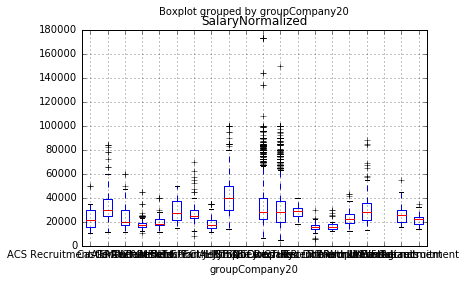

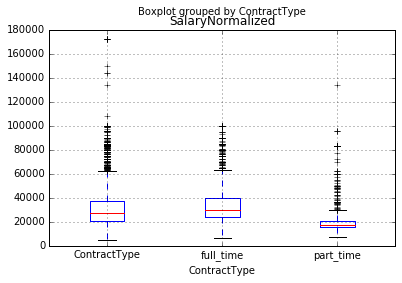

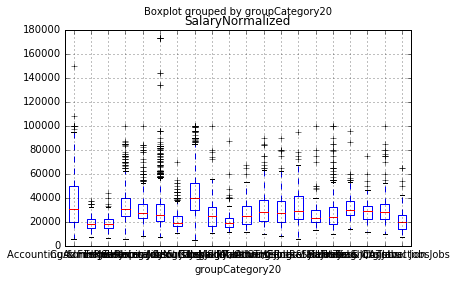

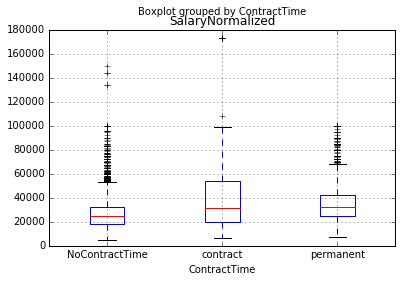

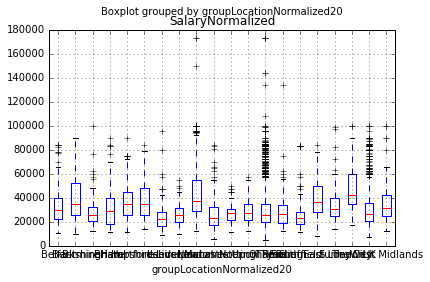

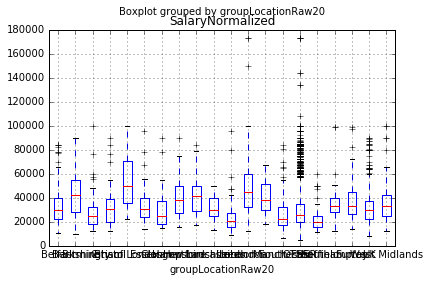

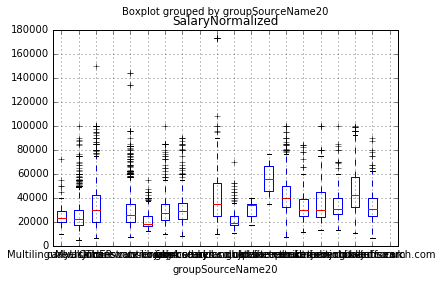

In [9]:
df1.boxplot(column='SalaryNormalized', by = 'groupCompany20')

df1.boxplot(column='SalaryNormalized', by = 'ContractType')

df1.boxplot(column='SalaryNormalized', by = 'groupCategory20')

df1.boxplot(column='SalaryNormalized', by = 'ContractTime')

df1.boxplot(column='SalaryNormalized', by = 'groupLocationNormalized20')

df1.boxplot(column='SalaryNormalized', by = 'groupLocationRaw20')

df1.boxplot(column='SalaryNormalized', by = 'groupSourceName20')

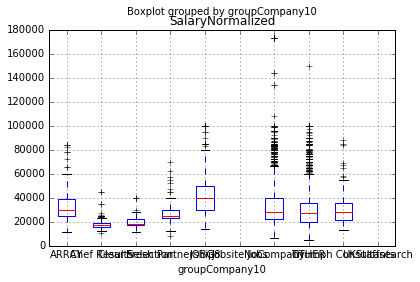

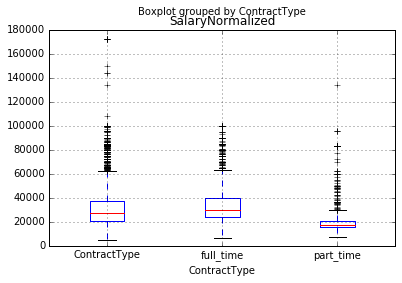

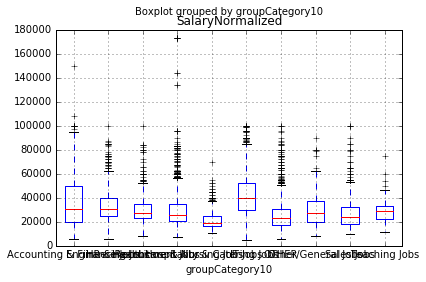

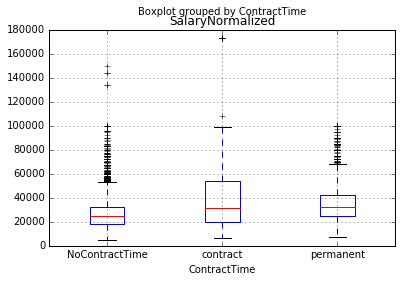

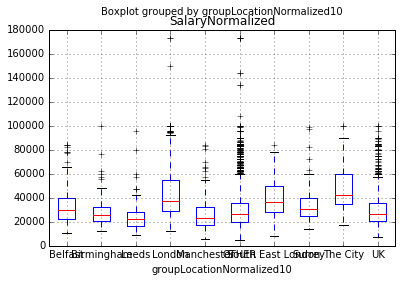

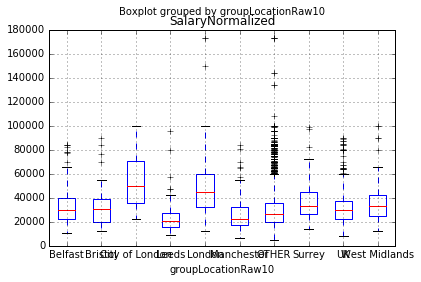

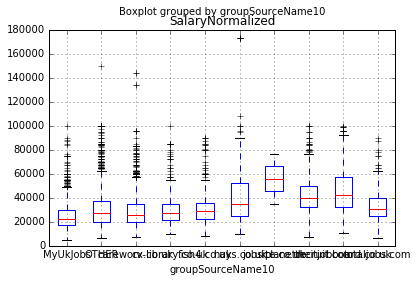

In [10]:
df1.boxplot(column='SalaryNormalized', by = 'groupCompany10')

df1.boxplot(column='SalaryNormalized', by = 'ContractType')

df1.boxplot(column='SalaryNormalized', by = 'groupCategory10')

df1.boxplot(column='SalaryNormalized', by = 'ContractTime')

df1.boxplot(column='SalaryNormalized', by = 'groupLocationNormalized10')

df1.boxplot(column='SalaryNormalized', by = 'groupLocationRaw10')

df1.boxplot(column='SalaryNormalized', by = 'groupSourceName10')

### Let us fit a linear model using these six variables
The objective in this step is to fit different models with one of the varibles, and then add a second one, then a third one, and so on; in order to decrease the MAE.

In [11]:
def make_model(model,variable):
    data1 = variable
    data1=pd.get_dummies(data1)
    train=data1[(data1['origin_train']==1)]
    test=data1[(data1['origin_train']!=1)]
    test_K=test.drop("SalaryNormalized",1)
    Y=train['SalaryNormalized']
    mean_sa=Y.mean()
    X=train.iloc[:, 1:-2]
    test_K=test_K.iloc[:,:-2]
    
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    
    from sklearn import metrics
   
    model.fit(X_train,y_train)
    try:
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
    except IndexError as er:
        print(er)
    except Exception as er:
        print("unexpected error happened")
    finally:
            train_score = 0
            test_score = 0
    pass

    train_mse = metrics.mean_squared_error(model.predict(X_train), y_train)
    test_mse = metrics.mean_squared_error(model.predict(X_test), y_test)
   
    test_K["PredictedSalary"]=model.predict(test_K)
    Prediction_K=test_K.iloc[:,-1]
    
    return {'train_score':train_score, 'test_score':test_score, \
            "train_mse":train_mse, "test_mse":test_mse, \
            "test_salary":y_test,"pred":lr.predict(X_test), "Prediction_K":Prediction_K, "mean_sa":mean_sa }

In [12]:
### Function to compute the MAE.
def MAE(mod):
    return abs(mod["test_salary"]-mod["pred"]).mean()

In [13]:
df1.columns

Index(['Category', 'Company', 'ContractTime', 'ContractType',
       'FullDescription', 'LocationNormalized', 'LocationRaw',
       'SalaryNormalized', 'SalaryRaw', 'SourceName', 'Title', 'origin',
       'groupCompany20', 'groupCategory20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10'],
      dtype='object')

### Applying Linear Regression

9526.099393939394
6283.00508


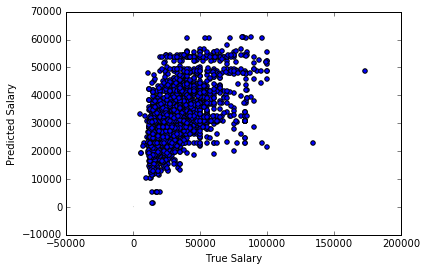

In [14]:
variable=df1[['SalaryNormalized','Category', 'ContractTime', 'ContractType',
       'groupCompany20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10','origin']]
from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=6)

mod1=make_model(lr,variable)
     
plt.scatter(mod1["test_salary"], mod1["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')
    
mod1["Prediction_K"].to_csv("submission1", header=True, index=True)

print(MAE(mod1))
print(abs(mod1["mean_sa"]-mod1["pred"]).mean())

## Using the Decision Tree Regressor

By keeping the same variables that give the best performance, let us use the Decision Tree Regressor.


9621.829696969697
6298.63342133


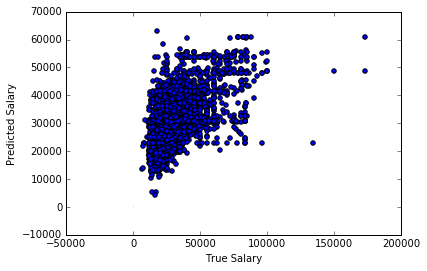

In [15]:
from sklearn import tree
model = tree.DecisionTreeRegressor()

variable=df1[['SalaryNormalized','Category', 'ContractTime', 'ContractType',
       'groupCompany20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10','origin']]

mod2=make_model(model,variable)
     
plt.scatter(mod2["test_salary"], mod2["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')
    
mod2["Prediction_K"].to_csv("submission2", header=True, index=True)

print(MAE(mod2))
print(abs(mod2["mean_sa"]-mod2["pred"]).mean())

## Using SVM

By keeping the same variables that give the best performance, let us use the Support Vector Machine.

#### Score on kaggle : 12126.89145, 11996.98628, 12050.30116 ; Some iterations are without the variables 'Title' and 'Full Description'

9711.116363636364
6345.40582279


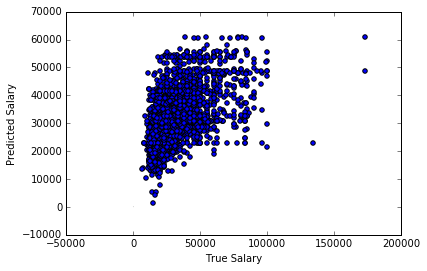

In [16]:
from sklearn import svm
model = svm.SVR(C=1e3,epsilon=0.2,kernel="rbf")

variable=df1[['SalaryNormalized','Category', 'ContractTime', 'ContractType',
       'groupCompany20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10','origin']]


mod3=make_model(model,variable)
     
plt.scatter(mod3["test_salary"], mod3["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')
    
mod3["Prediction_K"].to_csv("submission3", header=True, index=True)

print(MAE(mod3))
print(abs(mod3["mean_sa"]-mod3["pred"]).mean())

## Using K Nearest Neighbors Regressor

By keeping the same variables that give the best performance, let us use the KNN Regressor. 

##### Without using the variable 'Title', the scores obtained were : 12126.89145, 14312.06853, 13676.80640

from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=4, weights='uniform')

variable=df1[['SalaryNormalized','Category','ContractType','groupCompany20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10','groupCategory10', 
       'groupSourceName10', 'groupLocationNormalized10','groupLocationRaw10','origin']]


mod4 = make_model(KNN,variable)
     
plt.scatter(mod4["test_salary"], mod4["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')

    
mod4["Prediction_K"].to_csv("submission4", header=True, index=True)

print(MAE(mod4))
print(abs(mod4["mean_sa"]-mod4["pred"]).mean())

# Using Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, 
                              oob_score=False, n_jobs=-1,random_state=None, verbose=2, warm_start=False)

variable=df1[['SalaryNormalized','Category','ContractType','groupCompany20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10','groupCategory10', 
       'groupSourceName10', 'groupLocationNormalized10','groupLocationRaw10','origin']]


data1 = variable
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]
    
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    
from sklearn import metrics
model.fit(X_train,y_train)

train_mse = metrics.mean_squared_error(model.predict(X_train), y_train)
test_mse = metrics.mean_squared_error(model.predict(X_test), y_test)
    
test_K["PredictedSalary"]=model.predict(test_K)
Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission5", header=True, index=True)

print(train_mse)
print(test_mse)

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | ela

building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

# Using Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(loss='ls', learning_rate=0.05, n_estimators=1000, subsample=1.0, 
                                   min_samples_split=2,min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3, init=None, random_state=None,max_features=None, alpha=0.9, 
                                   verbose=2, max_leaf_nodes=None, warm_start=False, presort='auto')


variable=df1[['SalaryNormalized','Category', 'ContractTime', 'ContractType',
       'groupCompany20', 'groupCategory20', 'groupSourceName20',
       'groupLocationNormalized20', 'groupLocationRaw20', 'groupCompany10',
       'groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10','origin']]


data1 = variable
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]
    
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    
from sklearn import metrics
model.fit(X_train,y_train)

train_mse = metrics.mean_squared_error(model.predict(X_train), y_train)
test_mse = metrics.mean_squared_error(model.predict(X_test), y_test)
    
test_K["PredictedSalary"]=model.predict(test_K)
Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission6", header=True, index=True)

print(train_mse)
print(test_mse)

      Iter       Train Loss   Remaining Time 
         1   260807935.5072           41.12s
         2   256131907.4834           40.24s
         3   251896476.7759           41.68s
         4   248067092.6188           41.42s
         5   244586083.1203           41.86s
         6   241432574.7399           41.54s
         7   238554132.0481           42.15s
         8   235932572.3239           41.94s
         9   233536428.6391           42.39s
        10   231359369.4689           42.02s
        11   229366396.3499           42.31s
        12   227545485.3279           42.00s
        13   225153488.4342           42.28s
        14   223010610.7858           42.76s
        15   221546549.0657           42.86s
        16   219687517.1408           43.25s
        17   218401295.8940           43.30s
        18   216780020.5225           43.59s
        19   215641720.2777           43.87s
        20   214520208.2331           43.91s
        21   213526806.4956           43.82s
        2

# Let us clean the variable 'Title' and 'Full Description', and then add them in our different models

In [19]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
#print (stopwords.words("english")) 

In [20]:
def review_to_words( raw_review ):
    review_text = BeautifulSoup(raw_review, "lxml").get_text()   
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words ))   

In [ ]:
# Cleaning the variable 'Title'

In [21]:
num= df1["Title"].size

clean_Title = []

for i in range( 0, num ):                   
    clean_Title.append(review_to_words( df1["Title"].iloc[i:].any() ) )

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None,  max_features = 5000) 

tfidf_Title = vectorizer.fit_transform(clean_Title)


tfidf_Title = tfidf_Title.toarray()

print(tfidf_Title.shape)
print(tfidf_Title)

(15000, 4782)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [23]:
vocab = vectorizer.get_feature_names()
#print (vocab)

In [24]:
def extract_features(sort_feat, nb_feature):
    word=[]
    for i in range(len(sort_feat.iloc[-nb_feature:,:])):
            word.append(sort_feat.iloc[-nb_feature:,:].iloc[i][0])
    return(word)

In [25]:
dist = np.sum(tfidf_Title, axis=0)
tt=[]
ti=[]

for tag, count in zip(vocab, dist):
    ti.append(tag)
    tt.append(count)
    #print (count, tag)
    
sort_Title=pd.DataFrame(ti,tt).sort_index()

In [26]:
ctitle=pd.DataFrame(tfidf_Title, index=df1.index, columns=vocab)

In [ ]:
#top300=extract_features(sort_Title,300)

In [ ]:
#top_Title=ctitle[extract_features(sort_Title,300)]

# Cleanning Full Description

In [27]:
num= df1["FullDescription"].size

clean_FD = []

for i in range( 0, num ):                   
    clean_FD.append(review_to_words( df1["FullDescription"].iloc[i:].any() ) )

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None,  max_features = None) 

tfidf_FD = vectorizer.fit_transform(clean_FD)

tfidf_FD = tfidf_FD.toarray()

print(tfidf_FD.shape)
print(tfidf_FD)

(15000, 34738)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [29]:
vocab_FD = vectorizer.get_feature_names()
#print (vocab_FD)

In [30]:
dist = np.sum(tfidf_FD, axis=0)
tt=[]
ti=[]

for tag, count in zip(vocab_FD, dist):
    ti.append(tag)
    tt.append(count)
    #print (count, tag)
    
sort_FD=pd.DataFrame(ti,tt).sort_index()

In [115]:
sort_FD

,0
1,zuschuss
1,eton
1,etps
1,etrade
1,etrainer
1,etrali
1,etsi
1,ettering
1,ettiquette
1,etusr


In [31]:
cFullD=pd.DataFrame(tfidf_FD, index=df1.index, columns=vocab_FD)

In [ ]:
#top300FD=extract_features(sort_FD,300)

In [ ]:
#top_FD=cFullD[extract_features(sort_FD,300)]

# Applying the Machine Learning Model with Cleaned Title and Full Description

## Database Global

# Taking the length of each word and creating a new feature

In [32]:
length_Title=[]
for i in range(len(df1["Title"])) :
               length_Title.append(len(df1["Title"].iloc[i]))
df1["length_Title"]=length_Title

length_FD=[]
for i in range(len(df1["FullDescription"])) :
               length_FD.append(len(df1["FullDescription"].iloc[i]))
df1["length_FD"]=length_FD

In [35]:
varT= pd.concat([df1[['SalaryNormalized',"Category","length_Title","length_FD",'ContractTime',
       'groupCompany10','groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10']],
        cFullD[extract_features(sort_FD,500)],
        ctitle[extract_features(sort_Title,400)]], 
                axis=1, join_axes=[df1.index])
varT=pd.concat([varT, df1["origin"]], axis=1,join_axes=[df1.index] )

In [116]:
varT

,SalaryNormalized,length_Title,length_FD,ContractTime,ContractType,groupCompany10,groupCategory10,groupSourceName10,groupLocationNormalized10,groupLocationRaw10,...,care,home,support,developer,sales,senior,nurse,engineer,manager,origin
Id,,,,,,,,,,,,,,,,,,,,,
12612628,25000,27,348,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,OTHER,OTHER,...,0,0,0,0,0,0,0,0,0,train
12612830,30000,23,1649,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,OTHER,OTHER,...,0,0,0,0,0,0,0,1,0,train
12612844,30000,32,1771,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,OTHER,OTHER,...,0,0,0,0,0,0,0,0,0,train
12613049,27500,51,397,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,Surrey,OTHER,...,0,0,0,0,0,0,0,0,0,train
12613647,25000,42,216,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,Surrey,OTHER,...,0,0,0,0,0,0,0,0,0,train
13179816,25000,42,1602,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,OTHER,OTHER,...,0,0,0,0,0,0,0,0,0,train
14131336,75000,41,1364,permanent,ContractType,OTHER,Engineering Jobs,cv-library.co.uk,UK,OTHER,...,0,0,0,0,0,1,0,1,0,train
14663196,22000,68,2993,permanent,ContractType,OTHER,HR & Recruitment Jobs,cv-library.co.uk,Manchester,OTHER,...,0,0,0,0,0,0,0,0,0,train
14663197,23000,64,1893,permanent,ContractType,OTHER,HR & Recruitment Jobs,cv-library.co.uk,Leeds,OTHER,...,0,0,0,0,0,0,0,0,0,train


## Linear Model

7946.280629951123
10314.7931599


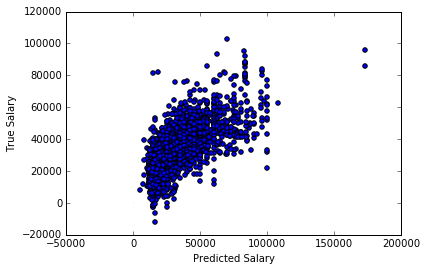

In [38]:
from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=6)

mod7=make_model(lr,varT)
     
plt.scatter(mod7["test_salary"], mod7["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel( 'Predicted Salary')

plt.ylabel('True Salary')
    
mod7["Prediction_K"].to_csv("submission7", header=True, index=True)

print(MAE(mod7))
print(abs(mod7["mean_sa"]-mod7["pred"]).mean())

## 10155.67498
## 10129.29072

# Using Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, min_samples_split=2,
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                              max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                              verbose=2, warm_start=False)


from sklearn import grid_search
param={'max_depth':[5,10,15], 'max_features':[100,500], "n_estimators":[100,500,1000]}

model = grid_search.GridSearchCV(rf, param, verbose=2)

data1 = varT
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]

model.fit(X,Y)

test_K["PredictedSalary"]=model.predict(test_K)

Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission8", header=True, index=True)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_features=100, n_estimators=100, max_depth=5 .................

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished



building tree 2 of 100building tree 1 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished



[CV] max_features=100, n_estimators=100, max_depth=5 .................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100building tree 21 of 100building tree 22 of 100building tree 23 of 100building tree 24 of 100building tree 25 of 100






building tree 26 of 100
building tree 27 of 100
building tree 28 of 100building tree 29 of 100
building tree 30 of 100
building tree 31 of 100

building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished



[CV] max_features=100, n_estimators=100, max_depth=5 .................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished



[CV] max_features=100, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished



[CV] max_features=100, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished



[CV] max_features=100, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished



[CV] max_features=100, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished



[CV] max_features=100, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished



[CV] max_features=500, n_estimators=100, max_depth=5 .................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished



[CV] max_features=500, n_estimators=100, max_depth=5 .................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished



[CV] max_features=500, n_estimators=100, max_depth=5 .................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=5 .................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished



[CV] max_features=500, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished



[CV] max_features=500, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=5 ................
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished



[CV] max_features=100, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished



[CV] max_features=100, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished



[CV] max_features=100, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished



[CV] max_features=100, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished



[CV] max_features=100, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=100, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished



[CV] max_features=500, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished



[CV] max_features=500, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished



[CV] max_features=500, n_estimators=100, max_depth=10 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=10 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.0s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   29.2s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=10 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished



[CV] max_features=100, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished



[CV] max_features=100, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished



[CV] max_features=100, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished



[CV] max_features=100, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=100, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=100, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=100, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=100, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished



[CV] max_features=500, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished



[CV] max_features=500, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished



[CV] max_features=500, n_estimators=100, max_depth=15 ................
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
b

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.5s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.5s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished



[CV] max_features=500, n_estimators=500, max_depth=15 ................
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   46.4s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   44.8s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



[CV] max_features=500, n_estimators=1000, max_depth=15 ...............
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tre

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.5min finished
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished



building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building

# Using Tree Regressor

7031.443654815197
10184.2540959


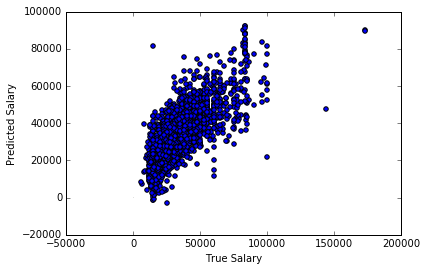

In [40]:
from sklearn import tree
model = tree.DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=10, min_samples_split=2, 
                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                   random_state=None, max_leaf_nodes=None, presort=False)

mod9=make_model(model,varT)
     
plt.scatter(mod9["test_salary"], mod9["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')
    
mod9["Prediction_K"].to_csv("submission9", header=True, index=True)

print(MAE(mod9))
print(abs(mod9["mean_sa"]-mod9["pred"]).mean())

# Using SVM

[LibSVM]6967.969518353626
9973.96785091


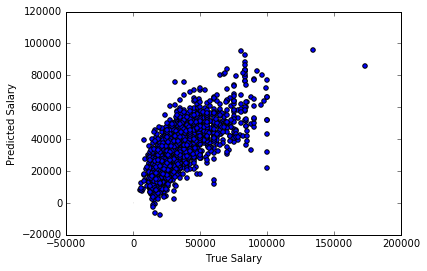

In [41]:
from sklearn import svm
model = svm.SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.2, 
                shrinking=True, cache_size=200, verbose=True, max_iter=-1)


mod10=make_model(model,varT)
     
plt.scatter(mod10["test_salary"], mod10["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel('True Salary')

plt.ylabel('Predicted Salary')
    
mod10["Prediction_K"].to_csv("submission10", header=True, index=True)

print(MAE(mod10))
print(abs(mod10["mean_sa"]-mod10["pred"]).mean())

# Using K N N

In [42]:
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(weights='uniform', algorithm='auto', p=2, 
                          metric='minkowski', metric_params=None, n_jobs=-1)
    
from sklearn import grid_search
param={'n_neighbors':[3,5,10], 'leaf_size':[10,24,50,100]}

model = grid_search.GridSearchCV(KNN, param, verbose=2)

data1 = varT
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]

model.fit(X,Y)

test_K["PredictedSalary"]=model.predict(test_K)

Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission11", header=True, index=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_neighbors=3, leaf_size=10 .....................................
[CV] ............................ n_neighbors=3, leaf_size=10 -   0.7s
[CV] n_neighbors=3, leaf_size=10 .....................................
[CV] ............................ n_neighbors=3, leaf_size=10 -   0.7s
[CV] n_neighbors=3, leaf_size=10 .....................................
[CV] ............................ n_neighbors=3, leaf_size=10 -   0.7s
[CV] n_neighbors=5, leaf_size=10 .....................................
[CV] ............................ n_neighbors=5, leaf_size=10 -   0.7s
[CV] n_neighbors=5, leaf_size=10 .....................................
[CV] ............................ n_neighbors=5, leaf_size=10 -   0.7s
[CV] n_neighbors=5, leaf_size=10 .....................................
[CV] ............................ n_neighbors=5, leaf_size=10 -   0.7s
[CV] n_neighbors=10, leaf_size=10 ....................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   26.4s finished


# Using Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(loss='ls', learning_rate=0.005, n_estimators=1500, subsample=1.0, 
                                   min_samples_split=2,min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3, init=None, random_state=None,max_features=None, alpha=0.9, 
                                   verbose=2, max_leaf_nodes=None, warm_start=False, presort='auto')




data1 = varT
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]
    

GBR.fit(X,Y)

    
test_K["PredictedSalary"]=GBR.predict(test_K)
Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission12", header=True, index=True)

print(train_mse)
print(test_mse)

# 10095.67096
# 9558.13645

      Iter       Train Loss   Remaining Time 
         1   260279172.8024           13.94m
         2   259659681.7656           11.35m
         3   259046370.1519           10.45m
         4   258439176.3215           10.00m
         5   257838039.2496            9.72m
         6   257242898.5200            9.54m
         7   256653694.3192            9.41m
         8   256070367.4303            9.30m
         9   255492813.3797            9.21m
        10   254921015.0847            9.15m
        11   254353910.6949            9.09m
        12   253792263.9116            9.04m
        13   253235220.1085            9.00m
        14   252683535.8068            8.96m
        15   252136365.3388            8.93m
        16   251594458.1085            8.90m
        17   251056977.3089            8.88m
        18   250524665.2897            8.86m
        19   249996694.0073            8.84m
        20   249473798.8192            8.82m
        21   248955160.3499            8.80m
        2

# Lets Apply Tf-idf

In [ ]:
## Applying Tf-idf on the variable 'Title'

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,1), stop_words="english", analyzer="word")
tfidf_Title=vectorizer.fit_transform(clean_Title)
tfidf_Title.get_shape()
voc_T=vectorizer.get_feature_names()

In [80]:
tft=pd.DataFrame(tfidf_Title.toarray(), columns=voc_T, index=df1.index)

In [ ]:
## Applying Tf-idf on the variable 'Full Description'

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,1), stop_words="english", analyzer="word")
tfidf_FD=vectorizer.fit_transform(clean_FD)
tfidf_FD.get_shape()

voc_FD=vectorizer.get_feature_names()

In [82]:
DFF=pd.DataFrame(tfidf_FD.toarray(), columns=voc_FD, index=df1.index)

In [83]:
def adjust(nb_feature,voc):
    tfword=[]
    for word in extract_features(sort_FD,300) :
        if word in voc:
            tfword.append(word)
    return(tfword)

In [ ]:
## -- Todo --
## We intend to improve upon the presence of some columns with the same names.
## We observe this in DFF[adjust(300,voc_FD)], tft[adjust(10,voc_T)]

In [88]:
yyy=DFF[adjust(400,voc_FD)]

In [92]:
yyy.columns=range(len(yyy.columns))

In [104]:
## Creating the working Database

varTf= pd.concat([df1[['SalaryNormalized',"Category","length_Title","length_FD",'ContractTime',
       'groupCompany10','groupCategory10', 'groupSourceName10', 'groupLocationNormalized10',
       'groupLocationRaw10']],
        yyy,
        tft[adjust(300,voc_T)]], 
                axis=1, join_axes=[df1.index])
varTf=pd.concat([varTf, df1["origin"]], axis=1,join_axes=[df1.index] )

# Applying the Machine Learning Technique

In [ ]:
## Linear Regression

from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=6)

mod7t=make_model(lr,varTf)
     
plt.scatter(mod7t["test_salary"], mod7t["pred"])

plt.plot([0, 50], [0, 50], '--k')

plt.xlabel( 'Predicted Salary')

plt.ylabel('True Salary')
    
mod7t["Prediction_K"].to_csv("submission7t", header=True, index=True)

print(MAE(mod7t))
print(abs(mod7t["mean_sa"]-mod7t["pred"]).mean())

## Random Forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None, min_samples_split=2,
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                              max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                              verbose=2, warm_start=False)


from sklearn import grid_search
param={'max_depth':[5,10,15], 'max_features':[100,500], "n_estimators":[100,500,1000]}

model = grid_search.GridSearchCV(rf, param, verbose=2)

data1 = varTf
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]

model.fit(X,Y)

test_K["PredictedSalary"]=model.predict(test_K)

Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission8t", header=True, index=True)

## K Nearest Neighbours

from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(weights='uniform', algorithm='auto', p=2, 
                          metric='minkowski', metric_params=None, n_jobs=-1)
    
from sklearn import grid_search
param={'n_neighbors':[3,5,10], 'leaf_size':[10,24,50,100]}

model = grid_search.GridSearchCV(KNN, param, verbose=2)

data1 = varTf
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]

model.fit(X,Y)

test_K["PredictedSalary"]=model.predict(test_K)

Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission11t", header=True, index=True)

In [111]:
## Gradient Descent Boosting

from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators=1500, subsample=1.0, 
                                   min_samples_split=2,min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3, init=None, random_state=None,max_features=None, alpha=0.9, 
                                   verbose=2, max_leaf_nodes=None, warm_start=False, presort='auto')


data1 = varTf
data1=pd.get_dummies(data1)
train=data1[(data1['origin_train']==1)]
test=data1[(data1['origin_train']!=1)]
test_K=test.drop("SalaryNormalized",1)
Y=train['SalaryNormalized']
mean_sa=Y.mean()
X=train.iloc[:, 1:-2]
test_K=test_K.iloc[:,:-2]
    

GBR.fit(X,Y)

    
test_K["PredictedSalary"]=GBR.predict(test_K)
Prediction_K=test_K.iloc[:,-1]
    
Prediction_K.to_csv("submission12t", header=True, index=True)

print(train_mse)
print(test_mse)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=1000, learning_rate=0.05 ...........................
      Iter       Train Loss   Remaining Time 
         1   270425510.4094            5.00m
         2   264577543.2055            4.56m
         3   259246696.1385            4.50m
         4   254388451.0721            4.41m
         5   249921397.2343            4.34m
         6   245840977.7093            4.29m
         7   242007094.7243            4.27m
         8   238462434.6295            4.25m
         9   235170986.0399            4.24m
        10   230607555.8135            4.17m
        11   227785680.1278            4.08m
        12   223672695.2410            4.00m
        13   221056184.7929            3.94m
        14   217425819.5851            3.88m
        15   215299426.2699            3.83m
        16   213065896.4171            3.79m
        17   210975159.0921            3.75m
        18   207879245.7972            3.72m
        19   2

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.6min finished
